<a href="https://colab.research.google.com/github/aireslucas/MachineLearning/blob/main/Atividade01_db02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset "Heart-Disease-App":
https://github.com/maxim-eyengue/Heart-Disease-App


Universidade Federal do Rio Grande do Norte - UFRN

**PPGEEC2318** - Machine Learning - Prof. Ivanovich Silva

Atividade 01

Lucas Aires da Costa Silva

#Imports

In [1]:
import numpy as np
import pandas as pd
import datetime
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
import torch.nn as nn
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

%matplotlib inline
plt.style.use('fivethirtyeight')

#Data Import

In [2]:
data = pd.read_csv("/content/drive/MyDrive/ML/cleaned_merged_heart_dataset.csv")

#Data preparation
________
Removing categorical data from dataset

In [3]:
data

,age,sex,cp,trestbps,chol,fbs,restecg,thalachh,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883,60,1,0,140,207,0,0,138,1,1.9,2,1,3,0
1884,46,1,0,140,311,0,1,120,1,1.8,1,2,3,0
1885,59,1,3,134,204,0,1,162,0,0.8,2,2,2,0
1886,54,1,1,154,232,0,0,164,0,0.0,2,1,2,0


In [4]:
del data["sex"]
del data["cp"]
del data["fbs"]
del data["restecg"]
del data["exang"]
del data["slope"]
del data["ca"]
del data["thal"]

In [5]:
data

,age,trestbps,chol,thalachh,oldpeak,target
0,63,145,233,150,2.3,1
1,37,130,250,187,3.5,1
2,41,130,204,172,1.4,1
3,56,120,236,178,0.8,1
4,57,120,354,163,0.6,1
...,...,...,...,...,...,...
1883,60,140,207,138,1.9,0
1884,46,140,311,120,1.8,0
1885,59,134,204,162,0.8,0
1886,54,154,232,164,0.0,0


#Archteture class

In [6]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

#Split dataset

In [7]:
data_full_train, X_test = train_test_split(data, test_size=0.2)
X_train, X_val = train_test_split(data_full_train, test_size=0.25)

In [8]:
print(f"train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")

train: 1132, val: 378, test: 378


In [9]:
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [10]:
y_train = X_train.target.values
y_val = X_val.target.values
y_test = X_test.target.values

In [11]:
del X_train["target"]
del X_val["target"]
del X_test["target"]

#Data Standard Scaler

In [12]:
# Initialize a StandardScaler instance
sc = StandardScaler()

# Fit the scaler only on the training data
# This computes the mean and standard deviation to be used for later scaling
sc.fit(X_train)

# Transform both training and validation sets
# Scale the training data
X_train = sc.transform(X_train)

# Apply the same transformation to the validation data
X_val = sc.transform(X_val)

#Data preparation

In [13]:
torch.manual_seed(42)

# Builds tensors from numpy arrays
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.reshape(-1, 1)).float()

# Builds dataset containing ALL data points
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Builds a loader of each set
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True
)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=16)

In [14]:
len(train_dataset)

1132

In [15]:
np.shape(x_val_tensor)

torch.Size([378, 5])

#Model configuration

In [16]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(42)
model = nn.Sequential()
model.add_module('linear', nn.Linear(5, 1))
#model.add_module('sigmoid', nn.Sigmoid())
print(model.state_dict())


# Defines a SGD optimizer to update the parameters
optimizer = optim.SGD(model.parameters(), lr=lr)

# Defines a BCE loss function
loss_fn = nn.BCEWithLogitsLoss()

OrderedDict([('linear.weight', tensor([[ 0.3419,  0.3712, -0.1048,  0.4108, -0.0980]])), ('linear.bias', tensor([0.0902]))])


#Training

In [17]:
n_epochs = 100

arch = Architecture(model, loss_fn, optimizer)
arch.set_loaders(train_loader, val_loader)
arch.set_seed(42)
arch.train(n_epochs)

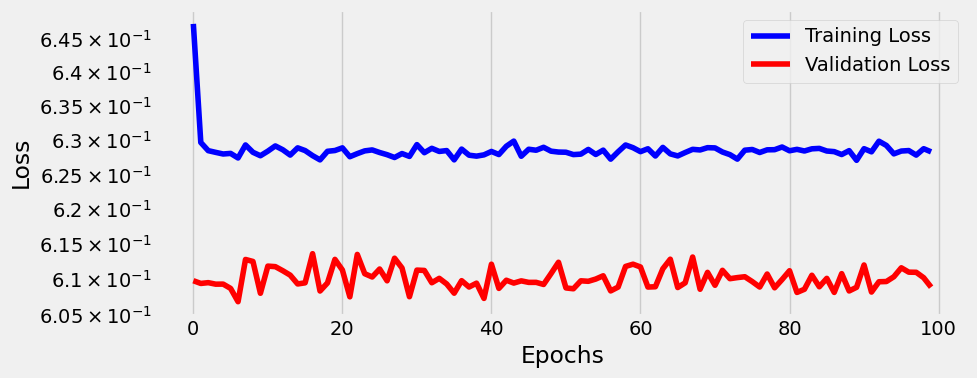

In [18]:
fig = arch.plot_losses()

In [19]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.0591, -0.1646, -0.1318,  0.4069, -0.5390]])), ('linear.bias', tensor([0.1364]))])


#Making predictions

In [20]:
# prediction logits (z)
logits_val = arch.predict(X_val)
logits_val

array([[ 1.1378284 ],
       [ 0.32180473],
       [ 0.911406  ],
       [ 0.38337314],
       [ 1.0237478 ],
       [ 1.4018389 ],
       [ 1.1878983 ],
       [-0.3442996 ],
       [ 0.18913405],
       [ 0.84381443],
       [-1.1982933 ],
       [ 0.66086143],
       [-0.54124945],
       [ 0.68303704],
       [ 0.93316627],
       [ 0.3914841 ],
       [-0.1864829 ],
       [ 1.0366708 ],
       [ 1.3972489 ],
       [ 0.1937486 ],
       [ 0.65450346],
       [-0.23919679],
       [-2.2928548 ],
       [ 0.25233063],
       [ 1.4051633 ],
       [ 0.1329377 ],
       [ 0.57498056],
       [ 1.1956336 ],
       [ 0.59982157],
       [-0.6988326 ],
       [ 0.93316627],
       [-0.71643054],
       [ 1.1627667 ],
       [ 0.06319078],
       [ 0.47071514],
       [-1.271277  ],
       [ 1.7101887 ],
       [ 0.1937486 ],
       [ 0.3849996 ],
       [ 0.29865795],
       [ 0.09246585],
       [ 1.3832923 ],
       [ 0.4667652 ],
       [-0.13067937],
       [ 0.52759254],
       [ 1

In [21]:
# prediction probabilities
prob_val = torch.sigmoid(torch.as_tensor(logits_val[:]).float())
prob_val

tensor([[0.7573],
        [0.5798],
        [0.7133],
        [0.5947],
        [0.7357],
        [0.8025],
        [0.7664],
        [0.4148],
        [0.5471],
        [0.6993],
        [0.2318],
        [0.6595],
        [0.3679],
        [0.6644],
        [0.7177],
        [0.5966],
        [0.4535],
        [0.7382],
        [0.8017],
        [0.5483],
        [0.6580],
        [0.4405],
        [0.0917],
        [0.5628],
        [0.8030],
        [0.5332],
        [0.6399],
        [0.7677],
        [0.6456],
        [0.3321],
        [0.7177],
        [0.3282],
        [0.7618],
        [0.5158],
        [0.6156],
        [0.2190],
        [0.8469],
        [0.5483],
        [0.5951],
        [0.5741],
        [0.5231],
        [0.7995],
        [0.6146],
        [0.4674],
        [0.6289],
        [0.8025],
        [0.6675],
        [0.2803],
        [0.4697],
        [0.3715],
        [0.5332],
        [0.7664],
        [0.6152],
        [0.7628],
        [0.3900],
        [0

In [22]:
classes = (prob_val >= 0.5).to(torch.int8)
classes

tensor([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [0],
        [1],
        [1],
        [0],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],

In [23]:
print(model.state_dict())

OrderedDict([('linear.weight', tensor([[-0.0591, -0.1646, -0.1318,  0.4069, -0.5390]])), ('linear.bias', tensor([0.1364]))])


#Classification Threshold

In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [25]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
threshold = 0.5

#Data Visualization

In [26]:
def probability_line(ax, y, probs, threshold, shift=0.0, annot=False, colors=None):
    if colors is None:
        colors = ['r', 'b']
    ax.grid(False)
    ax.set_ylim([-.1, .1])
    ax.axes.get_yaxis().set_visible(False)
    ax.plot([0, 1], [0, 0], linewidth=2, c='k', zorder=1)
    ax.plot([0, 0], [-.1, .1], c='k', zorder=1)
    ax.plot([1, 1], [-.1, .1], c='k', zorder=1)

    tn = (y == 0) & (probs < threshold)
    fn = (y == 0) & (probs >= threshold)
    tp = (y == 1) & (probs >= threshold)
    fp = (y == 1) & (probs < threshold)

    ax.plot([threshold, threshold], [-.1, .1], c='k', zorder=1, linestyle='--')
    ax.scatter(probs[tn], np.zeros(tn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[0], linewidth=3)
    ax.scatter(probs[fn], np.zeros(fn.sum()) + shift, c=colors[0], s=150, zorder=2, edgecolor=colors[1], linewidth=3)

    ax.scatter(probs[tp], np.zeros(tp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[1], linewidth=3)
    ax.scatter(probs[fp], np.zeros(fp.sum()) - shift, c=colors[1], s=150, zorder=2, edgecolor=colors[0], linewidth=3)

    ax.set_xlabel(r'$\sigma(z) = P(y=1)$')
    ax.set_title('Threshold = {}'.format(threshold))

    if annot:
        ax.annotate('TN', xy=(.20, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('FN', xy=(.20, -.08), c='k', weight='bold', fontsize=20)
        ax.annotate('FP', xy=(.70, .03), c='k', weight='bold', fontsize=20)
        ax.annotate('TP', xy=(.70, -.08), c='k', weight='bold', fontsize=20)
    return ax

In [27]:
def probability_contour(ax, model, device, X, y, threshold, cm=None, cm_bright=None):
    if cm is None:
        cm = plt.cm.RdBu
    if cm_bright is None:
        cm_bright = ListedColormap(['#FF0000', '#0000FF'])

    h = .02  # step size in the mesh

    x_min, x_max = -2.25, 2.25
    y_min, y_max = -2.25, 2.25

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    logits = model(torch.as_tensor(np.c_[xx.ravel(), yy.ravel()]).float().to(device))
    logits = logits.detach().cpu().numpy().reshape(xx.shape)

    yhat = sigmoid(logits)

    ax.contour(xx, yy, yhat, levels=[threshold], cmap="Greys", vmin=0, vmax=1)
    contour = ax.contourf(xx, yy, yhat, 25, cmap=cm, alpha=.8, vmin=0, vmax=1)
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
    # Plot the testing points
    #ax.scatter(X_val[:, 0], X_val[:, 1], c=y_val, cmap=cm_bright, edgecolors='k', alpha=0.6)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(r'$X_1$')
    ax.set_ylabel(r'$X_2$')
    ax.set_title(r'$\sigma(z) = P(y=1)$')
    ax.grid(False)

    ax_c = plt.colorbar(contour)
    ax_c.set_ticks([0, .25, .5, .75, 1])
    return ax

In [28]:
probabilities_val

array([0.7572807 , 0.579764  , 0.7132878 , 0.5946864 , 0.735702  ,
       0.8024755 , 0.766365  , 0.41476545, 0.54714304, 0.699268  ,
       0.23177896, 0.65945387, 0.367897  , 0.6644162 , 0.7177172 ,
       0.59663993, 0.45351392, 0.73820716, 0.80174696, 0.5482862 ,
       0.6580246 , 0.44048432, 0.09171645, 0.56275004, 0.80300194,
       0.53318554, 0.63991165, 0.76774716, 0.6456155 , 0.3320711 ,
       0.7177172 , 0.3281795 , 0.7618351 , 0.5157924 , 0.61555296,
       0.21903874, 0.84686077, 0.5482862 , 0.59507835, 0.57411444,
       0.5231    , 0.79951924, 0.6146178 , 0.4673766 , 0.62892145,
       0.8024755 , 0.66746277, 0.28029507, 0.4697205 , 0.37147683,
       0.53318554, 0.766365  , 0.61523235, 0.7627971 , 0.39003423,
       0.41999277, 0.55916435, 0.24654019, 0.3281795 , 0.70596695,
       0.67159265, 0.21123916, 0.72642475, 0.66429394, 0.43768293,
       0.5780342 , 0.21123916, 0.2404399 , 0.7066393 , 0.41335922,
       0.7347766 , 0.53318554, 0.73468304, 0.7433478 , 0.41080

#Metrics

In [29]:
def split_cm(cm):
    # Actual negatives go in the top row,
    # above the probability line
    actual_negative = cm[0]
    # Predicted negatives go in the first column
    tn = actual_negative[0]
    # Predicted positives go in the second column
    fp = actual_negative[1]

    # Actual positives go in the bottow row,
    # below the probability line
    actual_positive = cm[1]
    # Predicted negatives go in the first column
    fn = actual_positive[0]
    # Predicted positives go in the second column
    tp = actual_positive[1]

    return tn, fp, fn, tp

##True and false positive rates:
$$
\Large \text{TPR} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{FPR} = \frac{\text{FP}}{\text{FP + TN}}
$$

In [30]:
def tpr_fpr(cm):
    tn, fp, fn, tp = split_cm(cm)

    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)

    return tpr, fpr

##Precision and recall:
$$
\Large \text{Recall} = \frac{\text{TP}}{\text{TP + FN}} \ \ \  \text{Precision} = \frac{\text{TP}}{\text{TP + FP}}
$$

In [31]:
def precision_recall(cm):
    tn, fp, fn, tp = split_cm(cm)

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    return precision, recall

##Accuracy:
$$
\Large \text{Accuracy} = \frac{\text{TP+TN}}{\text{TP+TN+FP+FN}}
$$

#Predição

In [32]:
logits_val = arch.predict(X_val)
probabilities_val = sigmoid(logits_val).squeeze()
cm_thresh50 = confusion_matrix(y_val, (probabilities_val >= 0.5))
cm_thresh50

array([[116,  76],
       [ 38, 148]])

In [33]:
precision_recall(cm_thresh50)

(np.float64(0.6607142857142857), np.float64(0.7956989247311828))

In [34]:
acc = accuracy_score(y_val, (probabilities_val >= 0.5))
acc

0.6984126984126984

In [35]:
tpr_fpr(cm_thresh50)

(np.float64(0.7956989247311828), np.float64(0.3958333333333333))